In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ipywidgets opencv-python matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os

In [4]:
# Specify the directory where images are stored
image_folder = '/content/drive/MyDrive/SD_card_synced/'

# Get list of image files (assuming they're all valid image formats)
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))][:20]

# Load the images into a list
images = [cv2.imread(os.path.join(image_folder, file), cv2.IMREAD_GRAYSCALE) for file in image_files]


In [9]:
def apply_low_pass_filter(img, radius=30):
    # Apply FFT to the image
    f = np.fft.fft2(img)  # Forward FFT
    fshift = np.fft.fftshift(f)  # Shift the zero-frequency component to the center

    # Create a low-pass filter mask
    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, thickness=-1)  # Apply circular mask

    # Apply the mask to the shifted FFT
    fshift_filtered = fshift * mask

    # Inverse FFT to get the filtered image
    f_ishift = np.fft.ifftshift(fshift_filtered)  # Inverse shift
    img_back = np.fft.ifft2(f_ishift)  # Inverse FFT
    img_back = np.abs(img_back)  # Take the absolute value to get a real-valued result

    return img_back


In [14]:
def apply_hough_transform(img, min_radius, max_radius):
    # Convert filtered image to uint8 for Hough Circle Transform
    img = img.astype(np.uint8)

    # Detect circles in the image
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=30,
                               minRadius=min_radius, maxRadius=max_radius)

    # If circles are detected, draw them on the image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to color for circle visualization
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)
        return output
    else:
        return img  # If no circles detected, return original image

In [11]:
# Create interactive sliders for minRadius and maxRadius
min_radius_slider = widgets.IntSlider(value=20, min=0, max=100, step=1, description='Min Radius:')
max_radius_slider = widgets.IntSlider(value=50, min=0, max=100, step=1, description='Max Radius:')
radius_sliders = widgets.HBox([min_radius_slider, max_radius_slider])
display(radius_sliders)


In [12]:
def process_images(min_radius, max_radius):
    plt.figure(figsize=(20, 20))
    for idx, img in enumerate(images):
        # Apply low-pass filter
        filtered_img = apply_low_pass_filter(img)

        # Apply Hough Circle detection
        hough_img = apply_hough_transform(filtered_img, min_radius, max_radius)

        # Plot the results
        plt.subplot(4, 5, idx + 1)  # Adjust grid for 20 images
        plt.imshow(hough_img, cmap='gray')
        plt.title(f"Image {idx+1}")
        plt.axis('off')

    plt.show()

# Link the sliders to update the images
widgets.interactive(process_images, min_radius=min_radius_slider, max_radius=max_radius_slider)


interactive(children=(IntSlider(value=20, description='Min Radius:'), IntSlider(value=51, description='Max Rad…

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Low-pass filter function (with IFFT)
def apply_low_pass_filter(img, radius=30):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, thickness=-1)

    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    return img_back

# Hough Circle Transform with all adjustable parameters
def apply_hough_transform(img, dp, minDist, param1, param2, min_radius, max_radius):
    img = img.astype(np.uint8)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
                               param1=param1, param2=param2,
                               minRadius=min_radius, maxRadius=max_radius)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for i in circles[0, :]:
            cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)
        return output
    else:
        return img

# Create interactive widgets for all parameters
dp_slider = widgets.FloatSlider(value=1.0, min=1.0, max=3.0, step=0.1, description='dp:')
minDist_slider = widgets.IntSlider(value=20, min=1, max=100, step=1, description='minDist:')
param1_slider = widgets.IntSlider(value=50, min=1, max=200, step=1, description='param1:')
param2_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='param2:')
min_radius_slider = widgets.IntSlider(value=20, min=0, max=100, step=1, description='minRadius:')
max_radius_slider = widgets.IntSlider(value=50, min=0, max=100, step=1, description='maxRadius:')

# Display sliders
display(widgets.HBox([dp_slider, minDist_slider]))
display(widgets.HBox([param1_slider, param2_slider]))
display(widgets.HBox([min_radius_slider, max_radius_slider]))

# Batch process and visualize
def process_images(dp, minDist, param1, param2, min_radius, max_radius):
    plt.figure(figsize=(20, 20))
    for idx, img in enumerate(images):
        filtered_img = apply_low_pass_filter(img)
        hough_img = apply_hough_transform(filtered_img, dp, minDist, param1, param2, min_radius, max_radius)

        plt.subplot(4, 5, idx + 1)
        plt.imshow(hough_img, cmap='gray')
        plt.title(f"Image {idx+1}")
        plt.axis('off')

    plt.show()

# Link widgets with processing function
widgets.interactive(process_images,
                    dp=dp_slider,
                    minDist=minDist_slider,
                    param1=param1_slider,
                    param2=param2_slider,
                    min_radius=min_radius_slider,
                    max_radius=max_radius_slider)


interactive(children=(FloatSlider(value=1.0, description='dp:', max=3.0, min=1.0), IntSlider(value=20, descrip…

In [16]:
# @title Default title text
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Low-pass filter function (with IFFT)
def apply_low_pass_filter(img, radius=30):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, thickness=-1)

    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    return img_back

# Hough Circle Transform with Canny edge detection and adjustable parameters
def apply_hough_transform_with_canny(img, dp, minDist, param1, param2, min_radius, max_radius, canny_threshold1, canny_threshold2):
    # Apply Canny edge detection with adjustable thresholds
    edges = cv2.Canny(img, canny_threshold1, canny_threshold2)

    # Detect circles using the edges from Canny
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
                               param1=param1, param2=param2,
                               minRadius=min_radius, maxRadius=max_radius)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for i in circles[0, :]:
            cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)
        return output
    else:
        return img

# Create interactive widgets for Canny thresholds and Hough parameters
dp_slider = widgets.FloatSlider(value=1.0, min=1.0, max=3.0, step=0.1, description='dp:')
minDist_slider = widgets.IntSlider(value=20, min=1, max=100, step=1, description='minDist:')
param1_slider = widgets.IntSlider(value=50, min=1, max=200, step=1, description='param1:')
param2_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='param2:')
min_radius_slider = widgets.IntSlider(value=20, min=0, max=100, step=1, description='minRadius:')
max_radius_slider = widgets.IntSlider(value=50, min=0, max=100, step=1, description='maxRadius:')
canny_threshold1_slider = widgets.IntSlider(value=100, min=0, max=255, step=1, description='Canny Thresh 1:')
canny_threshold2_slider = widgets.IntSlider(value=200, min=0, max=255, step=1, description='Canny Thresh 2:')

# Display sliders
display(widgets.HBox([dp_slider, minDist_slider]))
display(widgets.HBox([param1_slider, param2_slider]))
display(widgets.HBox([min_radius_slider, max_radius_slider]))
display(widgets.HBox([canny_threshold1_slider, canny_threshold2_slider]))

# Batch process and visualize
def process_images(dp, minDist, param1, param2, min_radius, max_radius, canny_threshold1, canny_threshold2):
    plt.figure(figsize=(20, 20))
    for idx, img in enumerate(images):
        filtered_img = apply_low_pass_filter(img)
        hough_img = apply_hough_transform_with_canny(filtered_img, dp, minDist, param1, param2, min_radius, max_radius, canny_threshold1, canny_threshold2)

        plt.subplot(4, 5, idx + 1)
        plt.imshow(hough_img, cmap='gray')
        plt.title(f"Image {idx+1}")
        plt.axis('off')

    plt.show()

# Link widgets with processing function
widgets.interactive(process_images,
                    dp=dp_slider,
                    minDist=minDist_slider,
                    param1=param1_slider,
                    param2=param2_slider,
                    min_radius=min_radius_slider,
                    max_radius=max_radius_slider,
                    canny_threshold1=canny_threshold1_slider,
                    canny_threshold2=canny_threshold2_slider)


interactive(children=(FloatSlider(value=1.0, description='dp:', max=3.0, min=1.0), IntSlider(value=20, descrip…

<Figure size 2000x2000 with 0 Axes>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

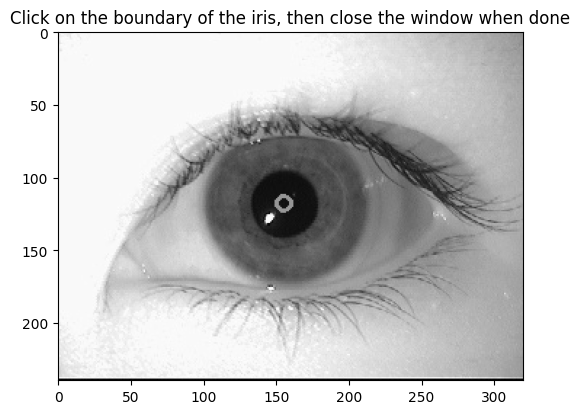

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the image (replace with your path)
image_path = '/content/drive/MyDrive/SD_card_synced/aeval1.jpg'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Display the image and allow the user to click on the iris boundary points
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title("Click on the boundary of the iris, then close the window when done")
points = plt.ginput(n=-1, timeout=0)  # n=-1 allows unlimited clicks, timeout=0 gives unlimited time
plt.close()

# Convert the points into a numpy array
points = np.array(points, dtype=np.int32)

# Step 2: Create a blank mask with the same size as the image
mask = np.zeros_like(img)

# Step 3: Fill the area inside the boundary points to create the mask
cv2.fillPoly(mask, [points], 255)

# Step 4: Apply the mask on the image (for visualization)
masked_img = cv2.bitwise_and(img, img, mask=mask)

# Step 5: Display the masked image
plt.figure(figsize=(6, 6))
plt.imshow(masked_img, cmap='gray')
plt.title("Masked Image with Iris Boundary")
plt.axis('off')
plt.show()
